# Consumption-Saving Model

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Iterate backwards](#toc2_)    
- 3. [Solve - value function interation (vfi)](#toc3_)    
  - 3.1. [Consumption function](#toc3_1_)    
  - 3.2. [Savings function](#toc3_2_)    
- 4. [Simulate](#toc4_)    
  - 4.1. [Monte Carlo](#toc4_1_)    
  - 4.2. [Historgram](#toc4_2_)    
- 5. [Compare simulation methods](#toc5_)    
- 6. [Solve - endogenous grid method (egm)](#toc6_)    
  - 6.1. [Compare solution methods](#toc6_1_)    
  - 6.2. [Consumption is proportional to $w$](#toc6_2_)    
- 7. [More simulation results](#toc7_)    
  - 7.1. [Income](#toc7_1_)    
  - 7.2. [Wealth](#toc7_2_)    
  - 7.3. [MPCs](#toc7_3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

**Content:** Solves and simulates a simple consumption-saving model.

**Solution methods:** *Value function iteration* (`vfi`) and the *endogenous grid-point method* (`egm`).

**Simulation methods:** Monte Carlo (`mc`) and the historgram method (`hist`).

**Packages you should know:**

1. [quantecon](https://quantecon.org/)
2. [EconModel](https://github.com/NumEconCopenhagen/EconModel) ([notebooks](https://github.com/NumEconCopenhagen/EconModelNotebooks))
2. [consav](https://github.com/NumEconCopenhagen/ConsumptionSaving) ([notebooks](https://github.com/NumEconCopenhagen/ConsumptionSavingNotebooks))

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numba as nb

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from ConSavModel import ConSavModelClass

## 1. <a id='toc1_'></a>[Setup](#toc0_)

In [2]:
model_vfi = ConSavModelClass()

**Question:** Which methods have been called now?

In [3]:
# unpack for easy access
par = model_vfi.par
sol = model_vfi.sol
sim = model_vfi.sim

**Grids:**

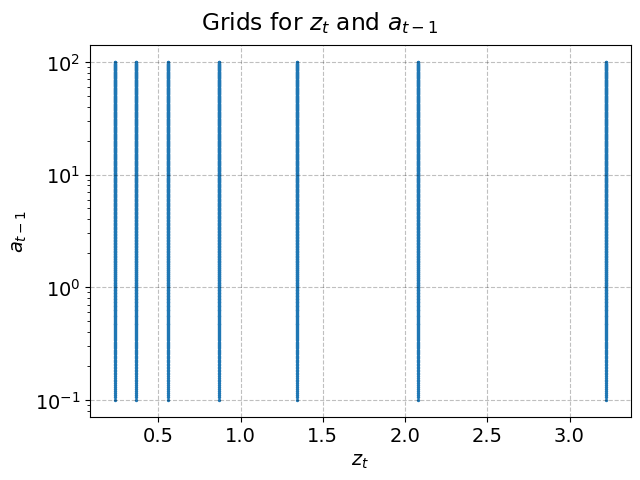

In [4]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

z_grid,a_grid = np.meshgrid(par.z_grid,par.a_grid,indexing='ij')
ax.scatter(z_grid,a_grid,2)

ax.set_yscale('log')
ax.set_xlabel('$z_t$')
ax.set_ylabel('$a_{t-1}$')

fig.suptitle('Grids for $z_t$ and $a_{t-1}$')
fig.tight_layout(pad=0.5)
fig.savefig('figs/grids.pdf')

**Transition matrix for $z_t$:**

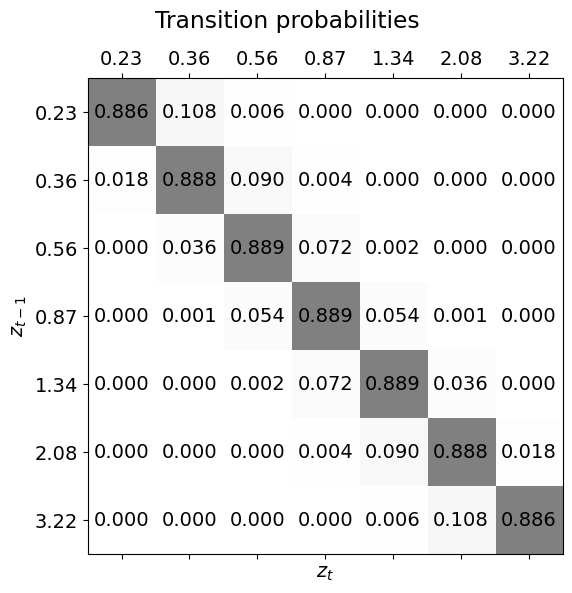

In [5]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
ax.grid(False)
h = ax.matshow(par.z_trans,cmap='Greys',alpha=0.5)

for (i, j), value in np.ndenumerate(par.z_trans):
    ax.text(j, i, f'{value:0.3f}', ha='center', va='center')
    
z_labels = [f'{z:.2f}' for z in par.z_grid]
xaxis = np.arange(par.z_grid.size)
ax.set_xticks(xaxis)
ax.set_xticklabels(z_labels) 
ax.set_yticks(xaxis)
ax.set_yticklabels(z_labels) 

ax.set_xlabel('$z_{t}$')
ax.set_ylabel('$z_{t-1}$')

fig.suptitle('Transition probabilities')
fig.tight_layout(pad=0.75)
fig.savefig('figs/z_trans.pdf')

**Ergodic distribution:**

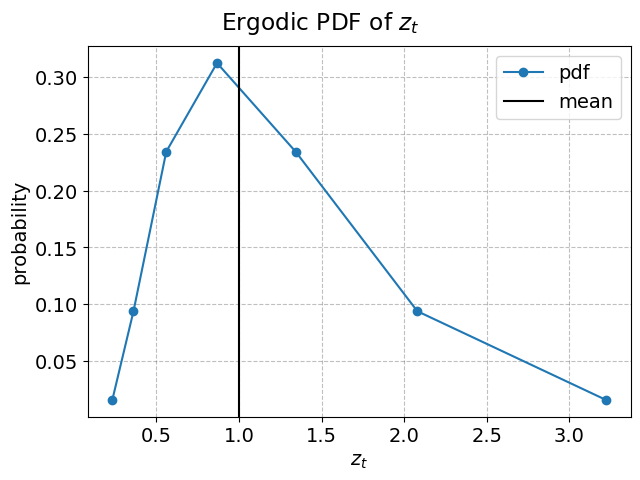

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
I = np.argsort(par.z_grid)
ax.plot(par.z_grid[I],par.z_ergodic[I],'-o',label='pdf')
ax.axvline(np.sum(par.z_ergodic*par.z_grid),color='black',label='mean')
ax.set_xlabel('$z_t$')
ax.set_ylabel('probability')
ax.legend(frameon=True)

fig.suptitle('Ergodic PDF of $z_t$')
fig.tight_layout(pad=0.5)
fig.savefig('figs/z_ergodic.pdf')

**Cummulative distributions:**

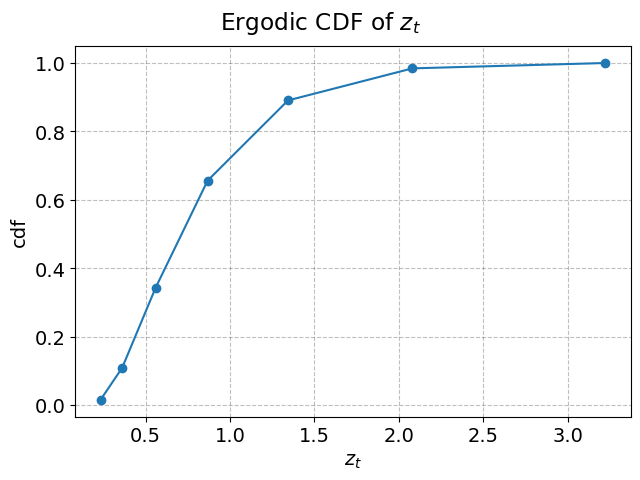

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
I = np.argsort(par.z_grid)
ax.plot(par.z_grid[I],np.cumsum(par.z_ergodic[I]),'-o')
ax.set_xlabel('$z_t$')
ax.set_ylabel('cdf')

fig.suptitle('Ergodic CDF of $z_t$')
fig.tight_layout(pad=0.5)
fig.savefig('figs/z_ergodic_cdf.pdf')

## 2. <a id='toc2_'></a>[Iterate backwards](#toc0_)

In [8]:
K = 101 # number of backward iterations

# a. allocate
c = np.zeros((K,par.Nz,par.Na))
a = np.zeros((K,par.Nz,par.Na))
vbeg = np.zeros((K,par.Nz,par.Na))
v = np.zeros((K,par.Nz,par.Na))
    
# b. iterate
for k in range(K):

    if k == 0: # last period = consume everything

        c_plus = (1+par.r)*par.a_grid[np.newaxis,:] + par.w*par.z_grid[:,np.newaxis]
        v_plus = c_plus**(1-par.sigma)/(1-par.sigma)
        vbeg_plus = par.z_trans@v_plus

    else: # plus is previous iteration

        vbeg_plus = vbeg[k-1]
        c_plus = c[k-1]

    model_vfi.solve_hh_backwards_vfi(vbeg_plus,c_plus,vbeg[k],c[k],a[k])

**Question:** What role does the argument `c_plus` play in `solve_hh_backwards_vfi`?

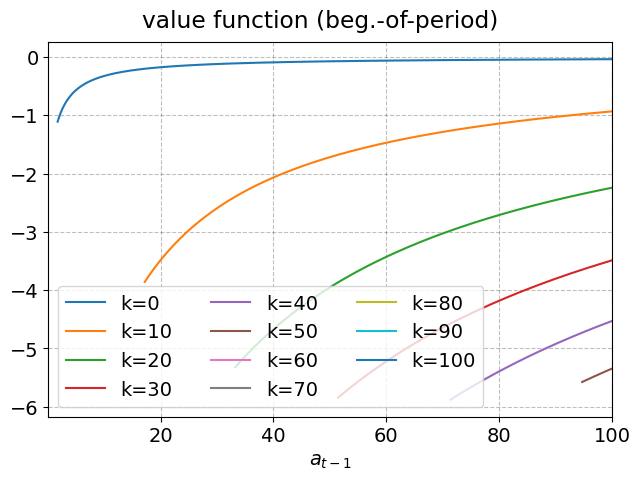

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for k in range(0,K,10):
    ax.plot(par.a_grid,vbeg[k,par.Nz//2,:],label=f'k={k}')
    
ax.legend(frameon=True,ncol=3)
ax.set_xlabel('$a_{t-1}$')
ax.set_xlim([par.a_grid[0],par.a_grid[-1]])

fig.suptitle('value function (beg.-of-period)')
fig.tight_layout(pad=0.5)
fig.savefig('figs/vbeg_func_convergence.pdf')

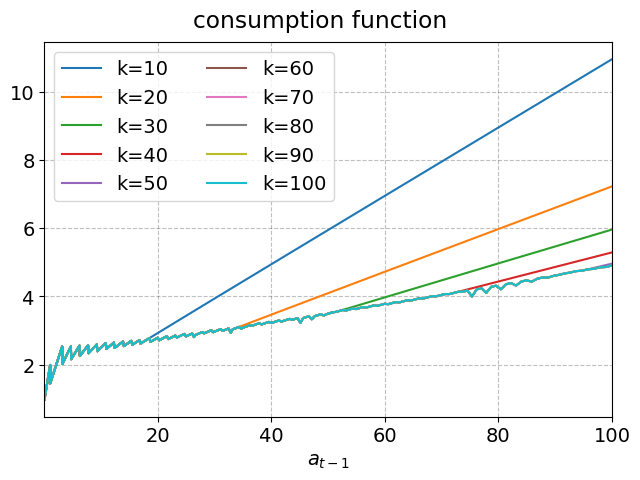

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for k in range(10,K,10):
    ax.plot(par.a_grid,c[k,par.Nz//2,:],label=f'k={k}')
    
ax.legend(frameon=True,ncol=2)
ax.set_xlabel('$a_{t-1}$')
ax.set_xlim([par.a_grid[0],par.a_grid[-1]])

fig.suptitle('consumption function')
fig.tight_layout(pad=0.5)
fig.savefig('figs/c_func_convergence.pdf')

## 3. <a id='toc3_'></a>[Solve - value function interation (vfi)](#toc0_)

In [11]:
model_vfi.solve(do_print=True,algo='vfi')

iteration    0 solved in 0.1 secs   [max abs. diff. 3.75e+00]
iteration    1 solved in 0.0 secs   [max abs. diff. 3.46e+00]
iteration    2 solved in 0.1 secs   [max abs. diff. 3.20e+00]
iteration    3 solved in 0.0 secs   [max abs. diff. 2.96e+00]
iteration    4 solved in 0.0 secs   [max abs. diff. 2.74e+00]
iteration    5 solved in 0.0 secs   [max abs. diff. 2.54e+00]
iteration    6 solved in 0.1 secs   [max abs. diff. 2.36e+00]
iteration    7 solved in 0.0 secs   [max abs. diff. 2.19e+00]
iteration    8 solved in 0.0 secs   [max abs. diff. 2.04e+00]
iteration    9 solved in 0.0 secs   [max abs. diff. 1.90e+00]
iteration  100 solved in 0.0 secs   [max abs. diff. 2.12e-02]
iteration  200 solved in 0.0 secs   [max abs. diff. 3.43e-04]
iteration  300 solved in 0.0 secs   [max abs. diff. 5.78e-06]
iteration  400 solved in 0.0 secs   [max abs. diff. 9.75e-08]
iteration  456 solved in 0.0 secs   [max abs. diff. 9.92e-09]
model solved in 17.6 secs


**Question:** What does ``par.tol_solve`` do?

### 3.1. <a id='toc3_1_'></a>[Consumption function](#toc0_)

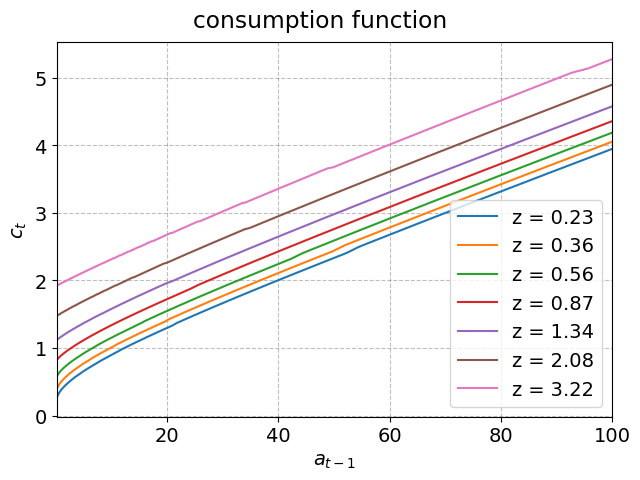

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for i_z in range(par.Nz):
    ax.plot(par.a_grid,sol.c[i_z,:],label=f'z = {par.z_grid[i_z]:.2f}')
    
ax.legend(frameon=True)
ax.set_xlabel('$a_{t-1}$')
ax.set_ylabel('$c_t$')
ax.set_xlim([par.a_grid[0],par.a_grid[-1]])

fig.suptitle('consumption function')
fig.tight_layout(pad=0.5)
fig.savefig('figs/c_func.pdf')

### 3.2. <a id='toc3_2_'></a>[Savings function](#toc0_)

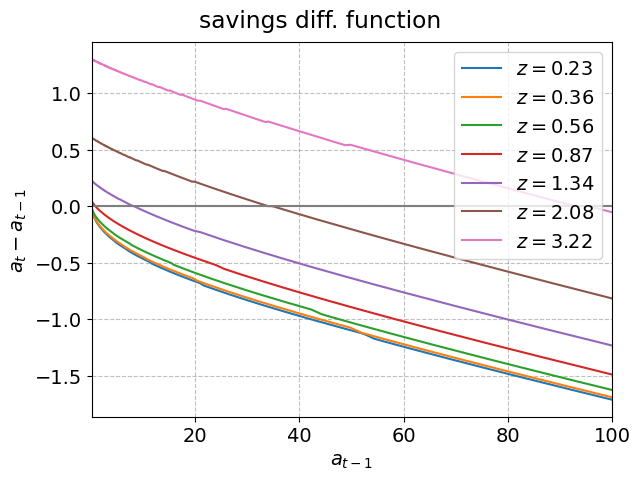

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for i_z in range(par.Nz):
    ax.plot(par.a_grid,sol.a[i_z,:]-par.a_grid,label=f'$z={par.z_grid[i_z]:.2f}$')

ax.plot(par.a_grid,np.zeros(par.Na))

ax.legend(frameon=True)
ax.set_xlabel('$a_{t-1}$')
ax.set_ylabel('$a_t-a_{t-1}$')
ax.set_xlim([par.a_grid[0],par.a_grid[-1]])

fig.suptitle('savings diff. function')
fig.tight_layout(pad=0.5)
fig.savefig('figs/a_diff_func.pdf')

**Question I:** What explains when savings respectively decrease or increase?

**Question II:** Is there convergence to a buffer-stock target?

## 4. <a id='toc4_'></a>[Simulate](#toc0_)

### 4.1. <a id='toc4_1_'></a>[Monte Carlo](#toc0_)

In [14]:
model_mc = model_vfi.copy()

In [15]:
model_mc.prepare_simulate(algo='mc')

model prepared for simulation in 0.4 secs


**Question:** What determines initial assets?

In [16]:
model_mc.simulate(algo='mc')

model simulated in 4.5 secs secs


**Asset distribution in final simulation period:**

Text(0.5, 0, '$a_{t-1}$')

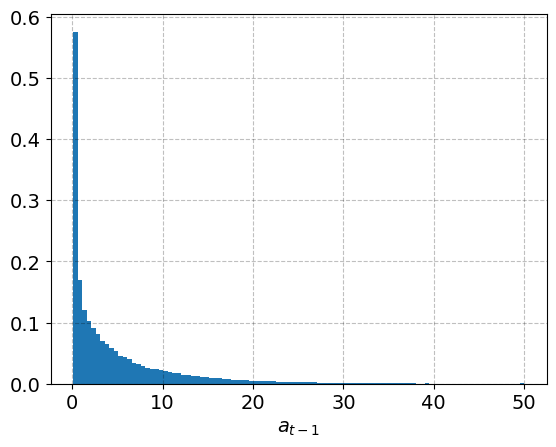

In [17]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(np.clip(model_mc.sim.a[-1],0,50),bins=100,density=True)
ax.set_xlabel('$a_{t-1}$')

### 4.2. <a id='toc4_2_'></a>[Historgram](#toc0_)

In [18]:
model_hist = model_vfi.copy()

In [19]:
model_hist.prepare_simulate(algo='hist')

model prepared for simulation in 0.0 secs


**Question:** What determines initial assets?

In [20]:
model_hist.simulate(algo='hist')

model simulated in 2.8 secs secs


Verify that distributions sum to 1.0:

In [21]:
for t in range(par.simT):
    assert np.isclose(np.sum(model_hist.sim.Dbeg[t]),1)
    assert np.isclose(np.sum(model_hist.sim.D[t]),1)

**Questions:** Does the seed for the random number generator matter?

## 5. <a id='toc5_'></a>[Compare simulation methods](#toc0_)

**Aggregate savings in last 100 periods on average:**

In [22]:
Nperiods = 100
A_mc = np.mean(model_mc.sim.a[-Nperiods:])
A_hist = np.sum(model_hist.sol.a*model_hist.sim.D[-Nperiods:])/Nperiods

print(f'{A_mc   = :7.4f}')
print(f'{A_hist = :7.4f}')

A_mc   =  4.7100
A_hist =  4.7326


**CDF:**

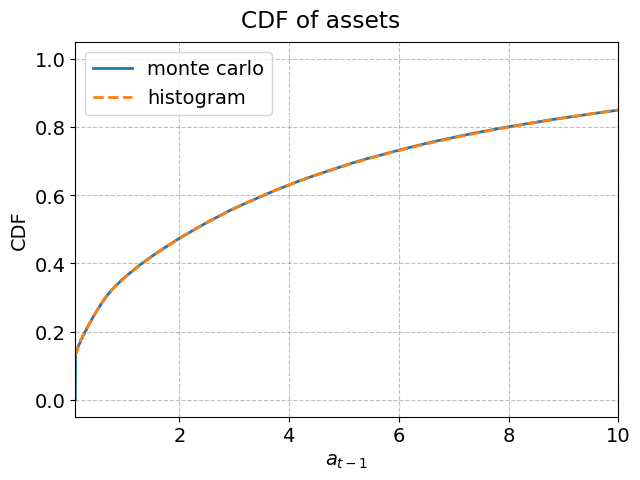

In [23]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

CDF_mc = np.zeros(par.Na)
for i_a in range(par.Na):
    CDF_mc[i_a] = np.sum(model_mc.sim.a[-1,:] < par.a_grid[i_a])/par.simN

CDF_hist = np.cumsum(np.sum(model_hist.sim.D[-1],axis=(0,)))

ax.plot(par.a_grid,CDF_mc,lw=2,label='monte carlo')
ax.plot(par.a_grid,CDF_hist,ls='--',lw=2,label='histogram')

ax.set_xlabel('$a_{t-1}$')
ax.set_ylabel('CDF')
ax.set_xlim([par.b,10.0])
ax.legend(frameon=True);

fig.suptitle('CDF of assets')
fig.tight_layout(pad=0.5)
fig.savefig('figs/a_cdf.pdf')

**Question 1:** How many liquidity constraints are there in the model?

**Question 2:** Look at the figure below. Does `simT` and `simN` matter for the distribution?

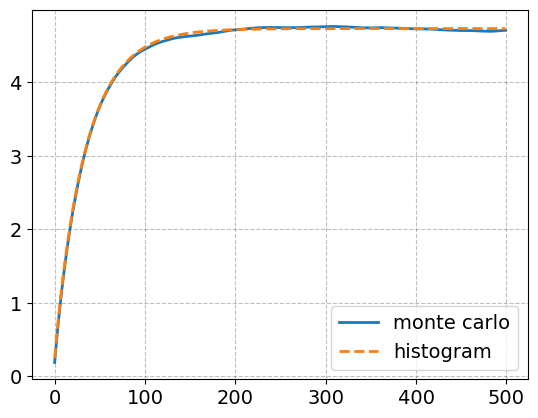

In [24]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

A_mc = np.mean(model_mc.sim.a,axis=1)
A_hist = np.sum(model_hist.sim.D*model_hist.sol.a,axis=(1,2))

ax.plot(A_mc,lw=2,label='monte carlo')
ax.plot(A_hist,ls='--',lw=2,label='histogram')

ax.legend(frameon=True);

**Question 3:** Why is the method below useful?

In [25]:
model_hist.simulate_hist_alt(do_print=True)

model simulated in 0.7 secs [429 iterations]


## 6. <a id='toc6_'></a>[Solve - endogenous grid method (egm)](#toc0_)

In [26]:
model_egm = model_vfi.copy()

In [27]:
model_egm.solve(do_print=True,algo='egm')

iteration    0 solved in 2.7 secs   [max abs. diff. 4.94e+01]
iteration    1 solved in 0.0 secs   [max abs. diff. 1.66e+01]
iteration    2 solved in 0.0 secs   [max abs. diff. 8.35e+00]
iteration    3 solved in 0.0 secs   [max abs. diff. 5.03e+00]
iteration    4 solved in 0.0 secs   [max abs. diff. 3.37e+00]
iteration    5 solved in 0.0 secs   [max abs. diff. 2.42e+00]
iteration    6 solved in 0.0 secs   [max abs. diff. 1.82e+00]
iteration    7 solved in 0.0 secs   [max abs. diff. 1.42e+00]
iteration    8 solved in 0.0 secs   [max abs. diff. 1.14e+00]
iteration    9 solved in 0.0 secs   [max abs. diff. 9.38e-01]
iteration  100 solved in 0.0 secs   [max abs. diff. 4.06e-03]
iteration  200 solved in 0.0 secs   [max abs. diff. 1.34e-05]
iteration  300 solved in 0.0 secs   [max abs. diff. 1.23e-08]
iteration  303 solved in 0.0 secs   [max abs. diff. 9.96e-09]
model solved in 2.8 secs


**Question:** Why is `egm` so much faster than `vfi`?

### 6.1. <a id='toc6_1_'></a>[Compare solution methods](#toc0_)

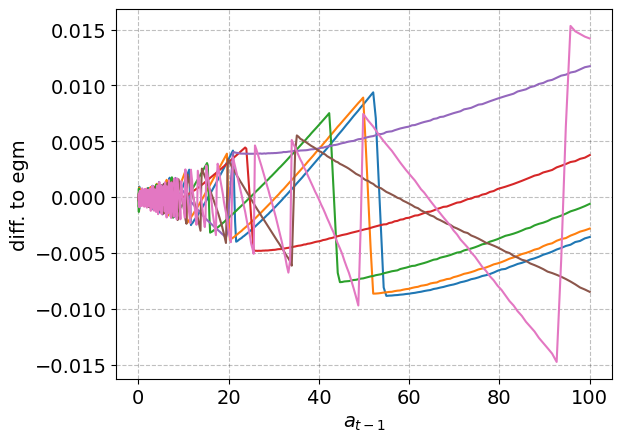

In [28]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for i_z in range(par.Nz):
    ax.plot(par.a_grid,model_vfi.sol.a[i_z,:]-model_egm.sol.a[i_z,:])
    
ax.set_xlabel('$a_{t-1}$');
ax.set_ylabel('diff. to egm');

### 6.2. <a id='toc6_2_'></a>[Consumption is proportional to $w$](#toc0_)

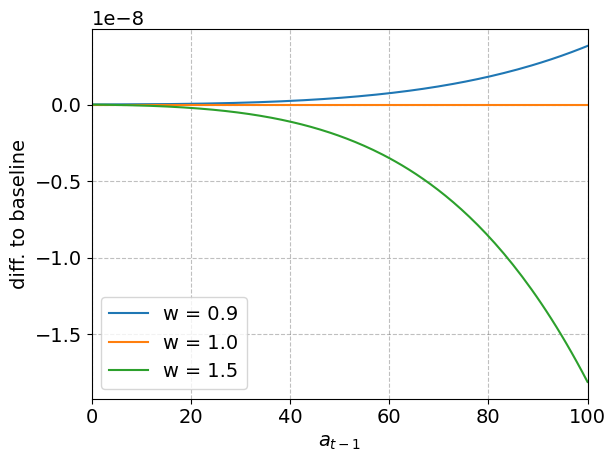

In [29]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

i_z = par.Nz//2
for w,ls in [(0.9,'-'),(1.0,'--'),(1.5,'--')]:
    
    fac = w/par.w
    
    model_ = model_egm.copy()
    model_.par.w = w
    model_.par.a_grid[:] = fac*model_.par.a_grid
    model_.solve(do_print=False,algo='egm')
    
    ax.plot(model_.par.a_grid/fac,model_.sol.c[i_z,:]/fac-model_egm.sol.c[i_z,:],label=f'{w = :.1f}')
             
ax.legend(frameon=True) 
ax.set_xlim([0,100])
ax.set_xlabel('$a_{t-1}$');
ax.set_ylabel('diff. to baseline');

## 7. <a id='toc7_'></a>[More simulation results](#toc0_)

In [30]:
model_egm.prepare_simulate(algo='hist')
model_egm.simulate_hist_alt()

model prepared for simulation in 0.0 secs
model simulated in 0.1 secs [429 iterations]


In [31]:
a = model_egm.sol.a
c = model_egm.sol.c
D = model_egm.sim.D_
Dbeg = model_egm.sim.Dbeg_

### 7.1. <a id='toc7_1_'></a>[Income](#toc0_)

In [32]:
mean_z = np.sum(D*par.z_grid[:,np.newaxis])
std_z = np.sqrt(np.sum(D*(par.z_grid[:,np.newaxis]-mean_z)**2))
print(f'mean z: {mean_z:5.2f}')
print(f'std. z: {std_z:5.2f}')

mean z:  1.00
std. z:  0.56


### 7.2. <a id='toc7_2_'></a>[Wealth](#toc0_)

In [33]:
# a. prepare
Da = np.sum(D,axis=0)
Da_cs = np.cumsum(Da)
mean_a = np.sum(Da*par.a_grid)
std_a = np.sqrt(np.sum(Da*(par.a_grid-mean_a)**2))

def percentile(par,Da_cs,p):
    
    # a. check first
    if p < Da_cs[0]: return par.a_grid[0]
    
    # b. find with loop
    i = 0
    while True:
        if p > Da_cs[i+1]:
            if i+1 >= par.Na: raise Exception()
            i += 1
            continue
        else:
            w = (p-Da_cs[i])/(Da_cs[i+1]-Da_cs[i])
            diff = par.a_grid[i+1]-par.a_grid[i]
            return par.a_grid[i]+w*diff
        
p25_a = percentile(par,Da_cs,0.25)
p50_a = percentile(par,Da_cs,0.50)
p95_a = percentile(par,Da_cs,0.95)
p99_a = percentile(par,Da_cs,0.99)

# b. print
print(f'mean a: {mean_a:6.3f}')
print(f'p25  a: {p25_a:6.3f}')
print(f'p50  a: {p50_a:6.3f}')
print(f'p95  a: {p95_a:6.3f}')
print(f'p99  a: {p99_a:6.3f}')
print(f'std. a: {std_a:6.3f}')

print(f'a = par.b: {Da[0]*100:.1f} %')
print(f'a <= 0: {np.sum(Da[par.a_grid <= 0])*100:.1f} %')

mean a:  4.734
p25  a:  0.452
p50  a:  2.280
p95  a: 17.678
p99  a: 29.069
std. a:  6.307
a = par.b: 12.8 %
a <= 0: 0.0 %


Or the policy function:

In [34]:
mean_a_alt = np.sum(D*a)
print(f'mean a: {mean_a_alt:6.3f} (using policy function)')

mean a:  4.734 (using policy function)


### 7.3. <a id='toc7_3_'></a>[MPCs](#toc0_)

**Calculate MPC from consumption function:**

In [35]:
MPC = (c[:,1:]-c[:,:-1])/((1+par.r)*(par.a_grid[1:]-par.a_grid[:-1]))

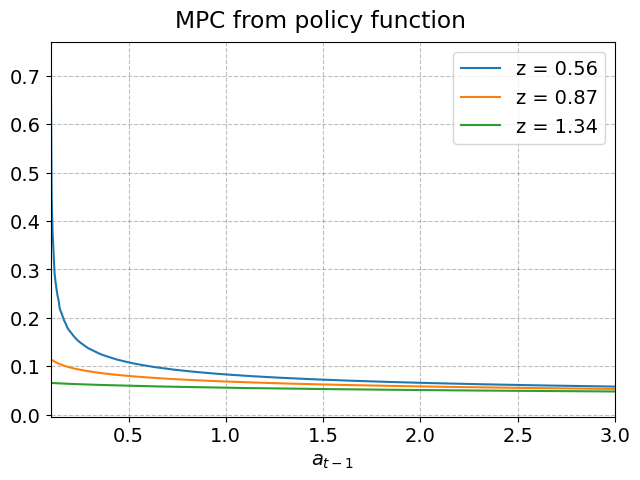

In [36]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for i_z in [par.Nz//2-1,par.Nz//2,par.Nz//2+1]:
    ax.plot(par.a_grid[:-1],MPC[i_z],label=f'z = {par.z_grid[i_z]:.2f}')

ax.set_xlim([par.b,3])
ax.set_xlabel('$a_{t-1}$')
ax.legend(frameon=True);

fig.suptitle('MPC from policy function')
fig.tight_layout(pad=0.5)
fig.savefig('figs/MPC_policy.pdf')

**Mean MPC:**

In [37]:
mean_MPC = np.sum(MPC*D[:,:-1])
print(f'mean MPC: {mean_MPC:6.3f}')

mean MPC:  0.167


**MPC distribution:**

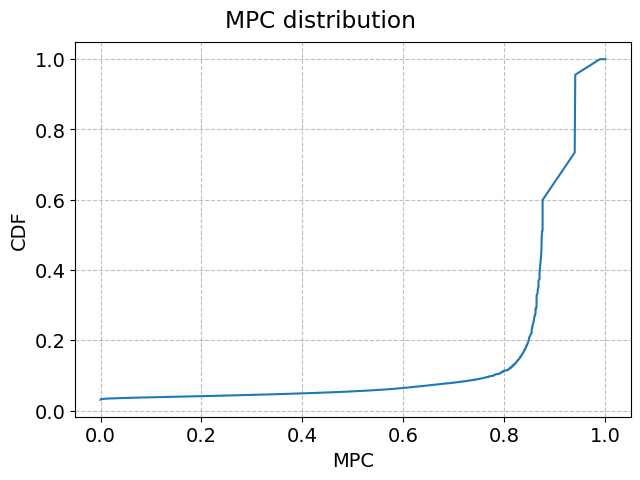

In [38]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

I = np.argsort(MPC.ravel())
ax.plot(np.cumsum(D[:,:-1].ravel()[I]),MPC.ravel()[I])

ax.set_xlabel('MPC')
ax.set_ylabel('CDF')

fig.suptitle('MPC distribution')
fig.tight_layout(pad=0.5)
fig.savefig('figs/MPC_dist.pdf')

A closer look at the MPC calculation.

In [39]:
for i_z in range(par.Nz):
    z = par.z_grid[i_z]
    print(f'z = {z:.2f}')
    for i_a in range(5):
        print(f' a_lag = {par.a_grid[i_a]:7.5f}, a = {a[i_z,i_a]:7.5f}, MPC = {MPC[i_z,i_a]:.2f}, D = {D[i_z,i_a]:.3f}')

z = 0.23
 a_lag = 0.10000, a = 0.10000, MPC = 1.00, D = 0.011
 a_lag = 0.10490, a = 0.10000, MPC = 1.00, D = 0.000
 a_lag = 0.10986, a = 0.10000, MPC = 0.60, D = 0.000
 a_lag = 0.11487, a = 0.10205, MPC = 0.51, D = 0.000
 a_lag = 0.11993, a = 0.10457, MPC = 0.51, D = 0.000
z = 0.36
 a_lag = 0.10000, a = 0.10000, MPC = 1.00, D = 0.049
 a_lag = 0.10490, a = 0.10000, MPC = 0.96, D = 0.001
 a_lag = 0.10986, a = 0.10022, MPC = 0.51, D = 0.001
 a_lag = 0.11487, a = 0.10272, MPC = 0.51, D = 0.001
 a_lag = 0.11993, a = 0.10525, MPC = 0.50, D = 0.001
z = 0.56
 a_lag = 0.10000, a = 0.10000, MPC = 0.73, D = 0.064
 a_lag = 0.10490, a = 0.10133, MPC = 0.45, D = 0.003
 a_lag = 0.10986, a = 0.10413, MPC = 0.37, D = 0.002
 a_lag = 0.11487, a = 0.10733, MPC = 0.33, D = 0.002
 a_lag = 0.11993, a = 0.11077, MPC = 0.29, D = 0.002
z = 0.87
 a_lag = 0.10000, a = 0.14827, MPC = 0.11, D = 0.005
 a_lag = 0.10490, a = 0.15269, MPC = 0.11, D = 0.000
 a_lag = 0.10986, a = 0.15718, MPC = 0.11, D = 0.000
 a_lag = 0